MODEL 2 - WHAT_NEXT_PREDICTION

***

In [1]:
# load packages 
import numpy as np
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

# model 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.python.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

# float format
pd.options.display.float_format = '{:,.2f}'.format

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data_cleaning dataframe

path1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/data_cleaning.csv' 
#path1 = '/content/drive/MyDrive/Colab Notebooks/data_cleaning.csv' 

data_cleaning = pd.read_csv(path1)
data_cleaning = data_cleaning.drop(['Unnamed: 0'],axis = 1)
data_cleaning.head(4)

,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
0,489647,A98815,73,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,ΕΡΤ1,Super League SOUROTI 2018/19 (L)(PANAITOLIKOS ...,115,"17,5",8769,6548,1
1,489647,A98815,73,F,10/12/18 00:00:00,TSTV,SPORTS,SPORTS-LIVE,"Eurosport 1 (International, GREEK)",Sports show (ALL SPORTS: WATTS ),15,"12,83",8770,7633,4
2,490873,babil,30,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"23,27",8771,7634,1
3,488305,9anti1,29,M,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"73,95",8772,7634,3


In [4]:
# create dictionary with USER_KEY as keys and USER_NAME as values
#users_dict = pd.Series(data_cleaning.USER_NAME.values,index=data_cleaning.USER_KEY).to_dict()
#users_dict

In [5]:
# sort the data - column "VIEW_DATE"
data_cleaning.sort_values('VIEW_DATE', inplace = True)
data_cleaning.head(3)

,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
1335051,2605247,OTT_12DS4Y0Z,94,M,01/12/18 00:00:00,VOD,MOVIES,ROMANTIC COMEDY,UNKNOWN,SNOWMANCE,"139,594","107,38",1343820,5486,4
1352122,484634,trelas4,34,F,01/12/18 00:00:00,VOD,MOVIES,"MYSTERY,THRILLER",UNKNOWN,THE LIMEHOUSE GOLEM,"61,269","47,13",1360891,5488,4
1352121,485002,GM210913,65,F,01/12/18 00:00:00,LIVE TV,SHOWS,SHOW,ΕΡΤ1,Sports - Weather(CENTRAL NEWS),65,"2,73",1360890,64,1


In [6]:
# group by USER_KEY - SRC_GENRE_DESC 
input = data_cleaning.groupby("USER_KEY")["SRC_GENRE_DESC"].apply(list)
print(input.shape)
input.head(5)

(102537,)


USER_KEY
-1         [TRUE STORY, ACTION,ADVENTURE, COMEDY, TRUE ST...
 461514     [SPORTS-LIVE, SPORTS-LIVE, UNKNOWN, SPORTS-LIVE]
 461564    [SPORTS-LIVE, SPORTS-LIVE, SPORTS-LIVE, SPORTS...
 461573    [SPORTS-LIVE, SPORTS-LIVE, SPORTS-LIVE, SPORTS...
 461607                                      [COMEDY,FAMILY]
Name: SRC_GENRE_DESC, dtype: object

In [7]:
# find unique elements of arrays 
input.explode().unique()

array(['TRUE STORY', 'ACTION,ADVENTURE', 'COMEDY', 'KIDS', 'DOCUMENTARY',
       'ROMANCE', 'ANIMATION', 'DRAMA', 'ROMANTIC COMEDY', 'THRILLER',
       'COMEDY DRAMA', 'CRIME,MYSTERY', 'ACTION,CRIME', 'CRIME,FANTASY',
       'COMEDY,FANTASY', 'CRIME,THRILLER', 'SCIFI,THRILLER', 'MYSTERY',
       'ANIMATION,KIDS', 'SOCIAL', 'HORROR', 'TALENT SHOW',
       'ACTION,MYSTERY', 'COMEDY,FAMILY', 'LIVE ACTION',
       'ADVENTURE,FAMILY', 'FANTASY', 'ACTION,SCIFI', 'SOCIAL,SPORT',
       'UNKNOWN', 'ADVENTURE', 'FAMILY', 'FANTASY,ROMANCE',
       'ACTION,THRILLER', 'WAR', 'COMEDY,CRIME', 'ADVENTURE,COMEDY',
       'SHOW', 'ACTION,COMEDY', 'SPORTS-LIVE', 'HORROR,MYSTERY', 'CRIME',
       'SCIFI', 'ACTION', 'ACTION,FANTASY', 'HORROR,TRUE STORY',
       'MYSTERY,THRILLER', 'COOKING', 'ACTION,WAR', 'MEDICAL DRAMA',
       'ACTION,ROMANTIC COMEDY', 'REALITY SHOW', 'ADVENTURE,SCIFI',
       'ADVENTURE,THRILLER', 'ADVENTURE,FANTASY', 'HISTORY',
       'MYSTERY,SCIFI', 'CRIME,HORROR', 'ADVENTURE,MYSTER

In [8]:
# create vocabulary - unique elements and size of unique elements 

vocab = list(input.explode().unique())
vocab_size = len(vocab)

In [9]:
# id2token - create tokens 

token2id = {i:j for j,i in enumerate(input.explode().unique())}

In [10]:
# token2id - numbering of the tokens 

id2token = {j:i for i,j in token2id.items()}

In [11]:
# get element indexed 1 - user 461514
input.iloc[1]

['SPORTS-LIVE', 'SPORTS-LIVE', 'UNKNOWN', 'SPORTS-LIVE']

In [12]:
# create sequence_data - at least 5 sequences in order to predict the 6th

sequence_data = []

for i in range(0,len(input)):
  if len(input.iloc[i]) >= 6:
    sequence_data.append(list(map(token2id.get, input.iloc[i])))


In [13]:
sequence_data[100]

[19, 29, 2, 29, 2, 29]

In [14]:
# To be used for all elements of each user 

from more_itertools import windowed

window_size = 5 

sequences = []
next_view = []
 
for j in range(0,len(sequence_data)):
  for i in windowed(sequence_data[j], window_size+1):
    sequences.append(i[:-1])
    next_view.append(i[-1])

In [15]:
# Check the above results - example given 

print(sequence_data[0]) # windowed 
print(sequences[0:5]) # first five windows 
print(next_view[0:5]) # first five target values

[0, 1, 2, 0, 3, 4, 2, 3, 3, 2, 2, 5, 3, 6, 2, 2, 7, 3, 8, 2, 3, 2, 2, 3, 2, 3, 3, 9, 2, 3, 7, 3, 7, 2, 2, 2, 10, 2, 9, 11, 2, 4, 12, 13, 14, 6, 2, 2, 2, 2, 2, 15, 2, 2, 3, 2, 3, 6, 5, 2, 3, 2, 4, 8, 16, 3, 3, 2, 14, 3, 8, 8, 2, 2, 2, 2, 11, 2, 17, 18, 19, 2, 2, 2, 20, 15, 2, 15, 2, 2, 21, 22, 3, 3, 3, 23, 2, 3, 5, 4, 8, 2, 2, 2, 2, 3, 20, 24, 7, 21, 2, 2, 21, 12, 22, 23, 23, 23, 2, 5, 15, 8, 8, 21, 2, 8, 8, 15, 2, 2, 21, 20, 2, 23, 8, 2, 21, 21, 25, 8, 20, 14, 26, 8, 2, 2, 2, 2, 2, 23, 27, 2, 19, 20, 27, 28, 3, 19, 23, 15, 29, 2, 3, 8, 19, 20, 8, 19, 2, 2, 0, 30, 29, 4, 2, 19, 2, 3, 31, 23, 8, 32, 21, 20, 33, 20, 6, 0, 11, 8, 7, 10, 19, 2, 34, 27, 33, 3, 33, 21, 3, 19, 3, 2, 3, 19, 17, 21, 8, 2, 21, 8, 3, 35, 17, 20, 34, 6, 23, 3, 2, 23, 2, 14, 8, 21, 2, 1, 7, 31, 3, 36, 2, 2, 21, 21, 8, 33, 33, 2, 3, 2, 23, 3, 2, 2, 37, 36, 31, 33, 33, 2, 33, 8, 3, 2, 3, 21, 3, 3, 6, 37, 2, 3, 3, 8, 38, 2, 8, 39, 0, 21, 2, 3, 2, 21, 3, 2, 29, 40, 3, 8, 33, 2, 8, 21, 11, 33, 4, 33, 3, 21, 38, 21, 2, 6,

In [16]:
print(len(sequences))
print(len(next_view))

1282013
1282013


In [17]:
# create X and Y 

X = []
Y = []

for i in range(0,len(sequences)):
    X.append(sequences[i])
    Y.append((next_view[i]))

In [18]:
print(X[1])

(1, 2, 0, 3, 4)


In [19]:
print(Y[1])

2


In [20]:
# convert to arrays X1, Y1
X1 = np.array(X)
Y1 = np.array(Y)

In [21]:
print(vocab_size)

65


In [22]:
Y1 = to_categorical(Y1, num_classes = vocab_size)

In [23]:
print(X1.shape)
print(Y1.shape)

(1282013, 5)
(1282013, 65)


In [24]:
# split into train and test datasets 

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X1, Y1)

print(sss)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, test_index in sss.split(X1, Y1):
     print("REST:", train_index, "TEST:", test_index)
     X_rest, X_test = X1[train_index], X1[test_index]
     Y_rest, Y_test = Y1[train_index], Y1[test_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

print("Shape of X_rest:", X_rest.shape)
print("Shape of Y_rest:", Y_rest.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
REST: [331718 172903  62391 ... 452051 492295 945968] TEST: [977931 412640 648170 ... 615593 135790 221107]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_test: (256403, 5)
Shape of Y_test: (256403, 65)
Shape of X_rest: (1025610, 5)
Shape of Y_rest: (1025610, 65)


In [25]:
# split into train and validation datasets 

from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss1.get_n_splits(X_rest, Y_rest)

print(sss1)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, val_index in sss1.split(X_rest, Y_rest):
     print("TRAIN:", train_index, "VAL:", val_index)
     X_train, X_val = X_rest[train_index], X_rest[val_index]
     Y_train, Y_val = Y_rest[train_index], Y_rest[val_index]

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)
TRAIN: [ 209031  126711    6259 ... 1020490  894168  414652] VAL: [553919 911660 969865 ... 891441 798914 598041]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of X_val: (256403, 5)
Shape of Y_val: (256403, 65)
Shape of X_train: (769207, 5)
Shape of Y_train: (769207, 65)


MODEL BUILDING

***

In [26]:
# Building the model 

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=5))
model.add(LSTM(256, return_sequences=True, name='LSTM_layer_1'))
model.add(Dropout(0.3,name='Dropout_layer_1'))
model.add(LSTM(256, name='LSTM_layer_2'))
model.add(Dropout(0.3, name='Dropout_layer_2'))
model.add(Dense(vocab_size, activation="softmax"))

Build model...


In [27]:
input_shape = ((None, 5))  
model.build(input_shape) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 50)             3250      
_________________________________________________________________
LSTM_layer_1 (LSTM)          (None, 5, 256)            314368    
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 5, 256)            0         
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 256)               525312    
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 65)                16705     
Total params: 859,635
Trainable params: 859,635
Non-trainable params: 0
__________________________________________________

In [28]:
# Define metrics

metrics = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_categorical_accuracy", dtype=None)

metrics1 = tf.keras.metrics.AUC(curve="ROC")

In [29]:
# Define callback - early stopping - quantity to be monitored "val_loss"
callback  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

In [30]:
# Define checkpoint callback - quantity to be monitored "val_loss"

filepath_1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model2/checkpoint_model2.h5' 
#filepath_1 = '/content/drive/MyDrive/Colab Notebooks/Saved_Models/Saved_Task2/Saved_Task2_model.h5' 
checkpoint = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=1, save_best_only=True)


In [31]:
# Compile the model 

model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate=0.002), metrics = ['accuracy', metrics, metrics1])

In [32]:
# fit the model 

model_fit = model.fit(X_train, Y_train, epochs = 100, batch_size = 128, validation_data = (X_val, Y_val), callbacks=[callback, checkpoint])

Epoch 1/100
6010/6010 [==============================] - 101s 16ms/step - loss: 2.4394 - accuracy: 0.3976 - top_5_categorical_accuracy: 0.6740 - auc: 0.9050 - val_loss: 2.3629 - val_accuracy: 0.4060 - val_top_5_categorical_accuracy: 0.6925 - val_auc: 0.9118

Epoch 00001: val_loss improved from inf to 2.36286, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model2/checkpoint_model2.h5
Epoch 2/100
6010/6010 [==============================] - 106s 18ms/step - loss: 2.3744 - accuracy: 0.4058 - top_5_categorical_accuracy: 0.6908 - auc: 0.9106 - val_loss: 2.3507 - val_accuracy: 0.4072 - val_top_5_categorical_accuracy: 0.6957 - val_auc: 0.9136

Epoch 00002: val_loss improved from 2.36286 to 2.35075, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model2/checkpoint_model2.h5
Epoch 3/100
6010/6010 [==============================] - 96s 16ms/step - loss: 2.3601 - accuracy: 0.4073 - top_5_categorical_accuracy: 0.6939 - auc: 0.9119 - val_loss: 2.34

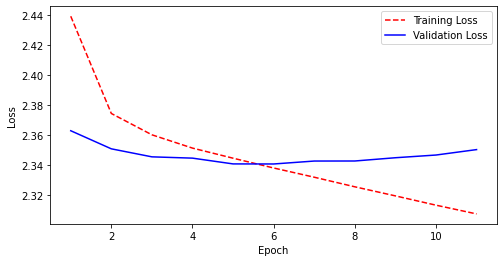

In [33]:
# Get training and test loss histories
training_loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
# Save model and architecture to single file

filepath_2 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model2/Saved_fmodel2.h5'
#filepath_2 = '/content/drive/MyDrive/Colab Notebooks/Saved_Models/Saved_Task2/Saved_Task2_model.h5' 

model.save(filepath_2, overwrite= True)

#Load the model
#loaded_model = load_model(filepath_2)

In [35]:
# save and load the weights of the model

filepath_3 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model2/Saved_fmodel2_weights.h5'
# filepath_3 = '/content/drive/MyDrive/Colab Notebooks/Saved_Models/Saved_Task2/Saved_Task2_fmodel_weights.h5' 

model.save_weights(filepath_3, overwrite= True)


# model.load_weights(filepath_3)

In [36]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=256)
print("test loss, test acc, test_top_5_categorical_acc, test_auc:", results)

Evaluate on test data
1002/1002 [==============================] - 8s 8ms/step - loss: 2.3456 - accuracy: 0.4083 - top_5_categorical_accuracy: 0.6969 - auc: 0.9131
test loss, test acc, test_top_5_categorical_acc, test_auc: [2.3455843925476074, 0.40830254554748535, 0.6969302296638489, 0.9131047129631042]


In [37]:
# Predict Next Sequence example for X_test sequence with index 0 

In [38]:
X_reshape = np.reshape(X_test[0],(1,len(X_test[0]),1))

In [39]:
predict_next_sequence = model.predict(X_reshape) 

In [40]:
predict_next_sequence

array([[5.3999677e-02, 1.9442994e-02, 5.2519463e-02, 1.1824854e-01,
        1.1500684e-02, 7.9007577e-03, 1.6880581e-02, 8.2316818e-03,
        2.7877251e-02, 3.9104741e-02, 1.1284987e-02, 2.0441005e-02,
        8.1458464e-02, 8.9880871e-04, 2.2155833e-03, 5.1847056e-02,
        1.6752866e-03, 4.1604144e-03, 3.1580792e-03, 2.0598078e-02,
        1.4897366e-01, 1.4184305e-03, 2.4808517e-03, 4.2345468e-02,
        4.8975153e-03, 4.2123026e-03, 4.0520234e-03, 1.3893766e-02,
        5.0868755e-03, 4.2338329e-03, 2.2524714e-03, 1.4738265e-02,
        6.6939887e-04, 5.7298008e-02, 5.4826145e-03, 7.1800966e-03,
        3.4996220e-03, 3.2269773e-03, 1.0061715e-02, 1.2260147e-02,
        4.3892171e-04, 2.1186594e-03, 1.2095500e-02, 1.1873625e-02,
        6.5577566e-03, 1.1171037e-02, 9.0844342e-03, 4.4083566e-04,
        3.0630855e-03, 5.4705155e-04, 4.6344874e-03, 1.7601917e-03,
        8.5684853e-03, 8.6149550e-04, 9.3791811e-03, 2.8830531e-04,
        1.4610506e-03, 6.2747707e-04, 2.1442613e

In [41]:
index_max = np.argmax(predict_next_sequence)
index_max

20

In [42]:
result = id2token.get(index_max)
result

'HORROR'

In [43]:
# What_Next_Prediction function 

def What_Next_Prediction(model, id2token, X, Y):
  
  preds = np.argmax(model.predict(X))
  predicted = ""
  
  for key, value in token2id.items():
      if value == preds:
          predicted = key
          break

  print("Input Values:", list(map(id2token.get, X)))
  print("Actual Value:", id2token.get(Y))
  print("Predicted Value:", predicted)

In [44]:
# check function - for  sequence indexed 0 

What_Next_Prediction(model, id2token, X_test[0], Y[0])

Input Values: ['KIDS', 'HORROR', 'HORROR', 'TRUE STORY', 'ACTION,CRIME']
Actual Value: DOCUMENTARY
Predicted Value: KIDS
